In [1]:
import torch
from constants import EMBEDDINGS_DIR, LABELS_DIR

In [2]:
encoder = "clap_ipa"
encoder_size = "base"

tira_embeddings = torch.load(EMBEDDINGS_DIR / f"tira_asr_{encoder}_{encoder_size}_embeddings.pt")
tira_embeddings_whitened = torch.load(EMBEDDINGS_DIR / f"tira_asr_{encoder}_{encoder_size}_whitened_embeddings.pt")

tira_embeddings.shape, tira_embeddings_whitened.shape

(torch.Size([16384, 512]), torch.Size([16384, 512]))

In [3]:
eng_embeddings = torch.load(EMBEDDINGS_DIR / f"tira_drz_{encoder}_{encoder_size}_embeddings.pt")
eng_embeddings_whitened = torch.load(EMBEDDINGS_DIR / f"tira_drz_{encoder}_{encoder_size}_whitened_embeddings.pt")
eng_embeddings_cross_whitened = torch.load(EMBEDDINGS_DIR / f"tira_drz_{encoder}_{encoder_size}_whitened_from_tira_asr_embeddings.pt")

eng_embeddings.shape, eng_embeddings_whitened.shape, eng_embeddings_cross_whitened.shape

(torch.Size([4548, 512]), torch.Size([4548, 512]), torch.Size([4548, 512]))

In [4]:
def embed_energy(embeddings):
    return embeddings.pow(2).sum(dim=1).pow(0.5)

def avg_embed_energy(embeddings):
    return embed_energy(embeddings).mean()

In [5]:
avg_embed_energy(torch.tensor([
    [3, 4],
    [0, 0]
]))

tensor(2.5000)

In [6]:
avg_embed_energy(tira_embeddings), avg_embed_energy(tira_embeddings_whitened)

(tensor(17.3552), tensor(22.4852))

In [7]:
avg_embed_energy(eng_embeddings), avg_embed_energy(eng_embeddings_whitened), avg_embed_energy(eng_embeddings_cross_whitened)

(tensor(13.9708), tensor(22.0378), tensor(28.4585))

Get LID ROC/AUC based on embedding energy alone

In [8]:
from sklearn.metrics import roc_curve, roc_auc_score

In [9]:
tira_X = tira_embeddings_whitened#[:eng_embeddings_cross_whitened.shape[0]]
eng_X = eng_embeddings_cross_whitened

embed_X = torch.concat([tira_X, eng_X])
embed_X.shape

torch.Size([20932, 512])

In [10]:
labels = torch.cat([torch.ones(tira_X.shape[0]), torch.zeros(eng_X.shape[0])])
labels.shape, labels.sum()

(torch.Size([20932]), tensor(16384.))

In [11]:
roc_auc_score(labels.numpy(), 1-embed_energy(embed_X).numpy())

0.8683902066112508

Visualize $t$-SNE of whitened embeddings

In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
himidan_mask_path = LABELS_DIR / "speaker_mask_HIM.pt"
himidan_mask = torch.load(himidan_mask_path)

tira_labels = torch.ones(tira_X.shape[0])

eng_labels = torch.zeros(eng_X.shape[0])
eng_labels[himidan_mask] = -1

all_labels = torch.cat([tira_labels, eng_labels])

In [17]:
embeds_2d = TSNE(n_components=2, random_state=42).fit_transform(embed_X.numpy())

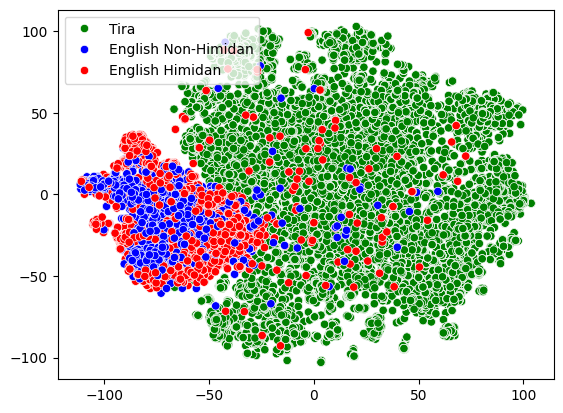

In [33]:
label_map = {1: "Tira", 0: "English Non-Himidan", -1: "English Himidan"}
label_names = [label_map[int(l.item())] for l in all_labels]

sns.scatterplot(
    x=embeds_2d[:,0],
    y=embeds_2d[:,1],
    hue=label_names,
    palette={"Tira":"green", "English Non-Himidan":"blue", "English Himidan":"red"},
    legend="full",
)
plt.show()

How much does ROC-AUC increase when we exclude Himidan English? When we only have Himidan English?

In [29]:
no_himidan_eng_X = eng_X[~himidan_mask]
no_himidan_eng_labels = torch.zeros(no_himidan_eng_X.shape[0])

embed_X_no_himidan = torch.concat([tira_X, no_himidan_eng_X])
labels_no_himidan = torch.cat([tira_labels, no_himidan_eng_labels])
roc_auc_score(labels_no_himidan.numpy(), 1-embed_energy(embed_X_no_himidan).numpy())

0.8606037360577544

In [ ]:
himidan_eng_X = eng_X[himidan_mask]
himidan_eng_labels = torch.zeros(himidan_eng_X.shape[0])

embed_X_himidan = torch.concat([tira_X, himidan_eng_X])
labels_himidan = torch.cat([tira_labels, himidan_eng_labels])
roc_auc_score(labels_himidan.numpy(), 1-embed_energy(embed_X_himidan).numpy())

0.8772451214324262